# 1) Stockage dans une DB

In [1]:
import pandas as pd
import numpy as np
import json

import boto3

import plotly.io as pio
pio.renderers.default = "iframe_connected"
import plotly.express as px

from sqlalchemy import create_engine, text
import psycopg2

In [2]:
dbuser = ''
dbpass = ''
dbhost = ''
dbname = ''

engine = create_engine(f"postgresql+psycopg2://{dbuser}:{dbpass}@{dbhost}/{dbname}", echo=True)

In [3]:
df_cities_weather=pd.read_csv('cities_weather.csv')
df_cities_weather.head()

,id,name,latitude,longitude,date,temperature,humidity,precipitation_probability,weather
0,0,Mont-Saint-Michel,48.635954,-1.51146,2021-12-21,4.27,71,0.00,Clouds
1,0,Mont-Saint-Michel,48.635954,-1.51146,2021-12-22,5.60,51,0.00,Clouds
2,0,Mont-Saint-Michel,48.635954,-1.51146,2021-12-23,9.42,90,0.05,Clouds
3,0,Mont-Saint-Michel,48.635954,-1.51146,2021-12-24,10.85,87,1.00,Rain
4,0,Mont-Saint-Michel,48.635954,-1.51146,2021-12-25,11.21,82,1.00,Rain


In [4]:
df_hotels=pd.read_csv('top10_best_hotel_per_city.csv')
df_hotels.head()

,city_id,city_name,hotel_name,url,score,description,latitude,longitude
0,0,Mont-Saint-Michel,Le Relais Saint Michel,https://www.booking.com/hotel/fr/le-relais-sai...,7.8,Vous pouvez bénéficier d'une réduction Genius...,48.617587,-1.510396
1,0,Mont-Saint-Michel,Les Terrasses Poulard,https://www.booking.com/hotel/fr/les-terrasses...,7.3,Vous pouvez bénéficier d'une réduction Genius...,48.635349,-1.510379
2,0,Mont-Saint-Michel,Hotel De La Digue,https://www.booking.com/hotel/fr/de-la-digue.f...,7.1,L'hôtel De La Digue est un établissement trad...,48.616882,-1.510918
3,0,Mont-Saint-Michel,Le Mouton Blanc,https://www.booking.com/hotel/fr/le-mouton-bla...,7.2,Vous pouvez bénéficier d'une réduction Genius...,48.636023,-1.509896
4,0,Mont-Saint-Michel,La Mère Poulard,https://www.booking.com/hotel/fr/la-mere-poula...,7.2,Vous pouvez bénéficier d'une réduction Genius...,48.635085,-1.510540


In [5]:
df_hotels.to_sql(
    "hotels",
    engine,
    if_exists='replace'
    )

2021-12-21 13:16:26,741 INFO sqlalchemy.engine.base.Engine select version()
2021-12-21 13:16:26,744 INFO sqlalchemy.engine.base.Engine {}
2021-12-21 13:16:26,758 INFO sqlalchemy.engine.base.Engine select current_schema()
2021-12-21 13:16:26,760 INFO sqlalchemy.engine.base.Engine {}
2021-12-21 13:16:26,773 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-12-21 13:16:26,775 INFO sqlalchemy.engine.base.Engine {}
2021-12-21 13:16:26,783 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-12-21 13:16:26,786 INFO sqlalchemy.engine.base.Engine {}
2021-12-21 13:16:26,794 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2021-12-21 13:16:26,795 INFO sqlalchemy.engine.base.Engine {}
2021-12-21 13:16:26,811 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

In [6]:
df_cities_weather.to_sql(
    "cities_weather",
    engine,
    if_exists='replace'
    )

2021-12-21 13:16:29,197 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2021-12-21 13:16:29,199 INFO sqlalchemy.engine.base.Engine {'name': 'cities_weather'}
2021-12-21 13:16:29,218 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2021-12-21 13:16:29,219 INFO sqlalchemy.engine.base.Engine {'name': 'cities_weather'}
2021-12-21 13:16:29,238 INFO sqlalchemy.engine.base.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind in ('r', 'p')
2021-12-21 13:16:29,240 INFO sqlalchemy.engine.base.Engine {'schema': 'public'}
2021-12-21 13:16:29,254 INFO sqlalchemy.engine.base.Engine 
            SELECT c.oid
            FROM pg_catalog.pg_class c
            LEFT JOIN pg_catalo

In [7]:
#classer les villes par températures moyenne, puis probabilité de précipitations moyenne
conn=engine.connect()
stmt=text('''SELECT MAX(id), name, MAX(latitude), MAX(longitude), AVG(temperature) as avg_temp, ROUND(AVG(humidity),5), 
             AVG(precipitation_probability) as avg_prec_prob, mode() WITHIN GROUP (ORDER BY weather)
             FROM cities_weather
             GROUP BY name
             ORDER BY avg_temp DESC, avg_prec_prob 
         ''')
result=conn.execute(stmt)

2021-12-21 13:16:31,230 INFO sqlalchemy.engine.base.Engine SELECT MAX(id), name, MAX(latitude), MAX(longitude), AVG(temperature) as avg_temp, ROUND(AVG(humidity),5), 
             AVG(precipitation_probability) as avg_prec_prob, mode() WITHIN GROUP (ORDER BY weather)
             FROM cities_weather
             GROUP BY name
             ORDER BY avg_temp DESC, avg_prec_prob 
         
2021-12-21 13:16:31,231 INFO sqlalchemy.engine.base.Engine {}


In [8]:
df_weather = pd.DataFrame(result.fetchall(), columns=['id', 'name', 'lat', 'lon','avg_temp', 'avg_hum', 'avg_prec', 'mode_weather'])

In [9]:
df_weather.head()

,id,name,lat,lon,avg_temp,avg_hum,avg_prec,mode_weather
0,33,Bayonne,43.493338,-1.475099,14.20250,73.12500,0.42000,Clouds
1,32,Biarritz,43.483252,-1.559278,14.03875,73.75000,0.41750,Rain
2,20,Marseille,43.296174,5.369953,12.04625,77.25000,0.57875,Rain
3,19,Cassis,43.218178,5.553394,11.97625,77.75000,0.56625,Rain
4,27,Collioure,42.525050,3.083155,11.63750,77.50000,0.18000,Clouds


In [10]:
df_weather.to_sql(
    "weather",
    engine,
    if_exists='replace'
)

2021-12-21 13:16:32,195 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2021-12-21 13:16:32,196 INFO sqlalchemy.engine.base.Engine {'name': 'weather'}
2021-12-21 13:16:32,216 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2021-12-21 13:16:32,218 INFO sqlalchemy.engine.base.Engine {'name': 'weather'}
2021-12-21 13:16:32,236 INFO sqlalchemy.engine.base.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind in ('r', 'p')
2021-12-21 13:16:32,237 INFO sqlalchemy.engine.base.Engine {'schema': 'public'}
2021-12-21 13:16:32,251 INFO sqlalchemy.engine.base.Engine 
            SELECT c.oid
            FROM pg_catalog.pg_class c
            LEFT JOIN pg_catalog.pg_namespace

In [11]:
#On récupère pour chaque ville les dix meilleurs hotels avec les prévisions météorologique
conn=engine.connect()
stmt=text('''SELECT weather.id, weather.name, weather.lat, weather.lon, weather.avg_temp, weather.avg_hum, weather.avg_prec, 
             mode_weather, hotels.hotel_name, hotels.url, hotels.score, hotels.description, hotels.latitude, 
             hotels.longitude
             FROM weather
             JOIN hotels
             ON weather.id=hotels.city_id
         ''')
result=conn.execute(stmt)


2021-12-21 13:16:32,661 INFO sqlalchemy.engine.base.Engine SELECT weather.id, weather.name, weather.lat, weather.lon, weather.avg_temp, weather.avg_hum, weather.avg_prec, 
             mode_weather, hotels.hotel_name, hotels.url, hotels.score, hotels.description, hotels.latitude, 
             hotels.longitude
             FROM weather
             JOIN hotels
             ON weather.id=hotels.city_id
         
2021-12-21 13:16:32,662 INFO sqlalchemy.engine.base.Engine {}


In [12]:
df_all_cities_hotels = pd.DataFrame(result.fetchall(), columns=['id', 'name', 'lat_city', 'lon_city', 'avg_temp',
                                                'avg_hum', 'avg_prec', 'mode_weather' , 'hotel_name', 'url', 'score', 
                                                'description', 'lat_hotel', 'lon_hotel'])

In [13]:
df_all_cities_hotels.to_csv('Top10 hotels per city and weather.csv', index=False)

In [14]:
#On ne garde que les cinq meilleurs villes selon nos critères
conn=engine.connect()
stmt=text('''SELECT  id, name, lat, lon, avg_temp, avg_hum, avg_prec, mode_weather
             FROM weather
             LIMIT 5
         ''')
result=conn.execute(stmt)

2021-12-21 13:16:33,977 INFO sqlalchemy.engine.base.Engine SELECT  id, name, lat, lon, avg_temp, avg_hum, avg_prec, mode_weather
             FROM weather
             LIMIT 5
         
2021-12-21 13:16:33,978 INFO sqlalchemy.engine.base.Engine {}


In [15]:
df_top5_cities = pd.DataFrame(result.fetchall(), columns=['id', 'name', 'lat', 'lon','avg_temp', 'avg_hum', 'avg_prec', 'mode_weather'])

In [16]:
df_top5_cities

,id,name,lat,lon,avg_temp,avg_hum,avg_prec,mode_weather
0,33,Bayonne,43.493338,-1.475099,14.20250,73.12500,0.42000,Clouds
1,32,Biarritz,43.483252,-1.559278,14.03875,73.75000,0.41750,Rain
2,20,Marseille,43.296174,5.369953,12.04625,77.25000,0.57875,Rain
3,19,Cassis,43.218178,5.553394,11.97625,77.75000,0.56625,Rain
4,27,Collioure,42.525050,3.083155,11.63750,77.50000,0.18000,Clouds


In [17]:
df_top5_cities.to_sql(
    "best_cities",
    engine,
    if_exists='replace'
)

2021-12-21 13:16:35,220 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2021-12-21 13:16:35,221 INFO sqlalchemy.engine.base.Engine {'name': 'best_cities'}
2021-12-21 13:16:35,241 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2021-12-21 13:16:35,242 INFO sqlalchemy.engine.base.Engine {'name': 'best_cities'}
2021-12-21 13:16:35,261 INFO sqlalchemy.engine.base.Engine SELECT c.relname FROM pg_class c JOIN pg_namespace n ON n.oid = c.relnamespace WHERE n.nspname = %(schema)s AND c.relkind in ('r', 'p')
2021-12-21 13:16:35,262 INFO sqlalchemy.engine.base.Engine {'schema': 'public'}
2021-12-21 13:16:35,275 INFO sqlalchemy.engine.base.Engine 
            SELECT c.oid
            FROM pg_catalog.pg_class c
            LEFT JOIN pg_catalog.pg_n

In [18]:
#Enfin on garde les dix meilleurs hotels pour les cinq villes séléectionnées 
conn=engine.connect()
stmt=text('''SELECT best_cities.name, hotels.hotel_name, hotels.url, hotels.score, hotels.description,
             hotels.latitude, hotels.longitude
             FROM best_cities
             JOIN hotels
             ON best_cities.id=hotels.city_id
         ''')
result=conn.execute(stmt)


2021-12-21 13:16:35,743 INFO sqlalchemy.engine.base.Engine SELECT best_cities.name, hotels.hotel_name, hotels.url, hotels.score, hotels.description,
             hotels.latitude, hotels.longitude
             FROM best_cities
             JOIN hotels
             ON best_cities.id=hotels.city_id
         
2021-12-21 13:16:35,745 INFO sqlalchemy.engine.base.Engine {}


In [19]:
df_final = pd.DataFrame(result.fetchall(), columns=['city_name', 'hotel_name', 'hotel_url', 'hotel_score', 'hotel_description', 'hotel_latitude', 'hotel_longitude'])
                                                 

In [20]:
df_final

,city_name,hotel_name,hotel_url,hotel_score,hotel_description,hotel_latitude,hotel_longitude
0,Marseille,B&B Hôtel Marseille Prado Vélodrome,https://www.booking.com/hotel/fr/b-amp-b-marse...,7.8,Vous pouvez bénéficier d'une réduction Genius...,43.268422,5.394097
1,Cassis,"The Originals Boutique, Hôtel Cassitel, Cassis",https://www.booking.com/hotel/fr/interhotel-ca...,7.9,"L’The Originals Boutique, Hôtel Cassitel, Cas...",43.213706,5.538958
2,Cassis,Best Western Plus Hôtel la Rade,https://www.booking.com/hotel/fr/la-rade-cassi...,8.0,Le Best Western Plus Hôtel la Rade est situé ...,43.215230,5.533697
3,Cassis,Hotel Le Golfe,https://www.booking.com/hotel/fr/le-golfe-cass...,7.6,"Situé dans le port de pêche de Cassis, l'Hôte...",43.214434,5.535295
4,Cassis,Royal Cottage,https://www.booking.com/hotel/fr/royal-cottage...,8.2,Installé à 5 minutes en voiture de la plage e...,43.216225,5.542900
5,Cassis,Le Clos Des Arômes,https://www.booking.com/hotel/fr/le-clos-des-a...,8.4,"Situé à Cassis, l'établissement Le Clos Des A...",43.216279,5.538166
6,Cassis,Hotel de La Plage - Mahogany,https://www.booking.com/hotel/fr/de-la-plage-c...,7.6,Vous pouvez bénéficier d'une réduction Genius...,43.213349,5.531263
7,Cassis,HôTEL LES VOLETS ROUGES - CASSIS,https://www.booking.com/hotel/fr/du-joli-bois-...,8.4,Doté d'une terrasse bien exposée et offrant u...,43.234829,5.511911
8,Cassis,Hôtel Les Roches Blanches Cassis,https://www.booking.com/hotel/fr/des-roches-bl...,8.8,Vous pouvez bénéficier d'une réduction Genius...,43.211337,5.529502
9,Cassis,Les Jardins de Cassis,https://www.booking.com/hotel/fr/les-jardins-d...,8.0,Situé dans un jardin de style méditerranéen d...,43.221840,5.543385


In [21]:
df_final.to_csv('Top10 hotel best cities.csv')

# 2) Création du bucket sur S3 et export du csv contenant les 10 meilleurs hotels pour chaque ville avec les prévisions météorologiques

In [22]:
session = boto3.Session(aws_access_key_id="", 
                        aws_secret_access_key="")

s3 = session.resource("s3")

bucket = s3.create_bucket(Bucket="jedha-project-kayak")

csv = df_all_cities_hotels.to_csv(index=False)

put_object = bucket.put_object(Key="all_cities_hotels.csv", Body=csv)

# 3) Visualisation des résultats pour les villes et hotels à l'aide de Plotly

In [23]:
#On utilise exp afin d'optimiser les différences de températures
df_weather['avg_temp_size'] = np.exp(df_weather['avg_temp'])

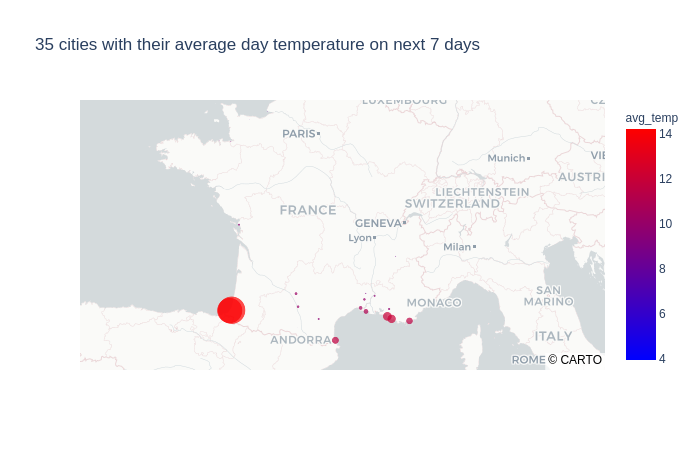

In [24]:
fig = px.scatter_mapbox(df_weather, hover_name='name', title='35 cities with their average day temperature on next 7 days', lat='lat', lon='lon', color='avg_temp', size='avg_temp_size', color_continuous_scale=px.colors.sequential.Bluered, mapbox_style="carto-positron", zoom=4)
fig.show("png")

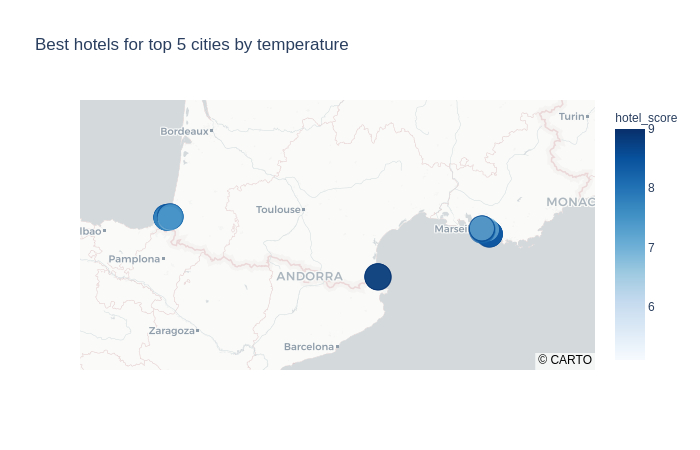

In [25]:
fig2 = px.scatter_mapbox(df_final, lat='hotel_latitude', lon='hotel_longitude', hover_name='hotel_name', title='Best hotels for top 5 cities by temperature', color='hotel_score', size='hotel_score', color_continuous_scale=px.colors.sequential.Blues, mapbox_style="carto-positron", zoom=5)
fig2.show("png")